# Stanisław Gajda 406643
# projekt 3

# symulujemy model Hulla-Whita
$$
dS_t = S_t r\,dt + S_t \sqrt{V_t}\,dW_t^S
$$
$$
dV_t = a(b - V_t)\,dt + \sigma V_t^{\alpha}\,dW_t^V
$$

In [1]:
import pandas as pd
import numpy as np

In [3]:
# generuje N skorelowanych przyrosty procesow wienera o zalozonym std
def generate_correlated_normals(rho, std, antithetic = False, N = 5):
    Z1 = np.random.normal(0, std, N)
    Z2 = np.random.normal(0, std, N)
    X = Z1
    Y = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    if(antithetic == False):
        return (X, Y)
    else:
        return (X, Y), (-X, -Y)

In [117]:
import numpy as np
def HWcall_MC_paths(S0=50, V0=0.06, r=0.05, sigma=0.4, a=2, b=0.04, alpha=0.5,
              rho=-0.7, T=2.0, n=500, M=10000, use_antithetic=True):
    dt = T / n
    # zeby na pewno M bylo parzyste
    M = M - M%2
    payoffs = np.zeros(M)
    all_S_paths = []
    all_V_paths = []
    # jezeli uzywamy zmiennych antytetycznych to liczba iteracji nam sie podwoi
    if(use_antithetic):
        num_loops = int(M/2)
    else:
        num_loops = M
 
    for i in range(num_loops):
        if use_antithetic:
            (dW_S, dW_V), (dW_Sa, dW_Va) = generate_correlated_normals(rho, std=np.sqrt(dt), antithetic=True, N=n)
        else:
            dW_S, dW_V = generate_correlated_normals(rho, std=np.sqrt(dt), antithetic=False, N=n)

        S, V = S0, V0
        if use_antithetic:
            Sa, Va = S0, V0
        S_tab = [S]
        V_tab = [V]
        if use_antithetic:
            S_tab_a = [Sa]
            V_tab_a = [Va]

        for j in range(n):
            dS = S * (r * dt + np.sqrt(V) * dW_S[j])
            dV = a * (b - V) * dt + sigma * V**alpha * dW_V[j] + 0.5 * sigma**2 * alpha * V**(2*alpha - 1) * (dW_V[j]**2 - dt)
            V += dV
            S += dS
            V = max(V, 0)
            S = max(S, 0)
            S_tab.append(S)
            V_tab.append(V)

            if use_antithetic:
                dSa = Sa * (r * dt + np.sqrt(Va) * dW_Sa[j])
                dVa = a * (b - Va) * dt + sigma * Va**alpha * dW_Va[j] + 0.5 * sigma**2 * alpha * Va**(2*alpha - 1) * (dW_Va[j]**2 - dt)
                Va += dVa
                Sa += dSa
                Sa = max(Sa, 0)
                Va = max(Va, 0)
                S_tab_a.append(Sa)
                V_tab_a.append(Va)

        all_S_paths.append(S_tab)
        all_V_paths.append(V_tab)
        if use_antithetic:
            all_S_paths.append(S_tab_a)
            all_V_paths.append(V_tab_a)

    return np.array(all_S_paths), np.array(all_V_paths)


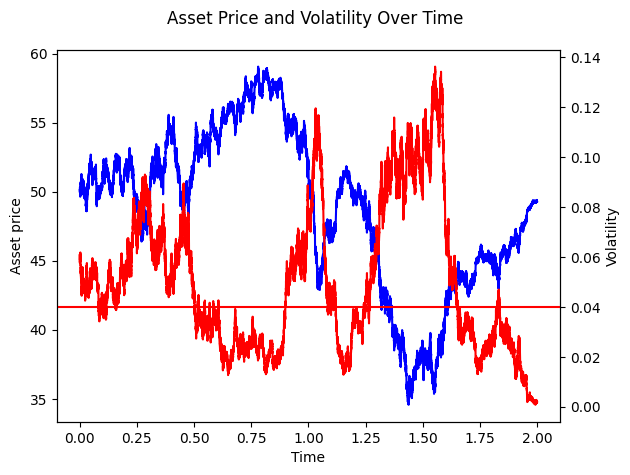

In [118]:
from matplotlib import pyplot as plt 
N = 10 ** 5
S_paths, V_paths = HWcall_MC_paths(M = 10, a = 2, n = N)
x_vals = [2/N * x for x in range(N+1)]
fig, ax1 = plt.subplots()
# Plot S_paths on primary y-axis
ax1.plot(x_vals, S_paths[1, :], color='blue', label='Asset Price (S)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset price')

# Create a second y-axis for V_paths
ax2 = ax1.twinx()
ax2.plot(x_vals, V_paths[1, :], color='red', label='Volatility (V)')
ax2.set_ylabel('Volatility')
ax2.axhline(0.04, color = "red")
fig.suptitle('Asset Price and Volatility Over Time')
fig.tight_layout()
plt.show()

## na wykresie widać wyraźnie ujemną autokorelację zmiennosci i ceny
## poziomą linią zaznaczyłem długoterminową średnią do której zbiega zmienność

In [164]:
def HWcall_MC(S0=50, V0=0.06, r=0.05, sigma=0.4, a=2, b=0.04, alpha=0.5,
              rho=-0.7, T=2.0, K=45, n=500, M=100, use_antithetic=True):
    S, _ = HWcall_MC_paths(S0=S0, V0=V0, r=r, sigma=sigma, a=a, b=b, alpha=alpha,
              rho=-0.7, T=T, n=n, M=M, use_antithetic=use_antithetic)

    payoffs = np.maximum(0, S[:, n] - K) * np.exp(-r * T)
    if use_antithetic:
        pair_means = payoffs.reshape(-1, 2).mean(axis=1)
        price = pair_means.mean()
        standard_error = pair_means.std(ddof=1) / np.sqrt(pair_means.size)
    else:
        price = payoffs.mean()
        standard_error = payoffs.std(ddof=1) / np.sqrt(M)
    interval = (price - standard_error * 1.96, price+standard_error * 1.96)
    
    return price, interval

# EX 3

In [171]:
S = HWcall_MC(S0 = 50, V0 = 0.06, r = 0.05, sigma = 0.4,a = 2,b = 0.04,alpha = 0.5,rho = -0.7,T = 2,K = 45,n = 500,M = 10000, use_antithetic=True)
print(f"Price: {S[0]}")
print(f"CI: {S[1]}")

Price: 11.507971275175302
CI: (np.float64(11.384591565052784), np.float64(11.631350985297821))


In [172]:
S = HWcall_MC(S0 = 50, V0 = 0.06, r = 0.05, sigma = 0.4,a = 2,b = 0.04,alpha = 0.5,rho = -0.7,T = 2,K = 45,n = 500,M = 10000, use_antithetic=False)
print(f"Price: {S[0]}")
print(f"CI: {S[1]}")

Price: 11.315999857438571
CI: (np.float64(11.104917328801285), np.float64(11.527082386075858))


In [175]:
(11.5079 - 11.3845)/(11.3159 - 11.1049)

0.5848341232227537

In [177]:
C = HWcall_MC(S0 = 50, V0 = 0.06, r = 0.05, sigma = 0.4,a = 2,b = 0.04,alpha = 0.5,rho = -0.7,T = 2,K = 45,n = 500,M = 100000, use_antithetic=True)
print("ANTITHETIC VARIABLES")
print(f"Price: {C[0]}")
print(f"CI: {C[1]}")

ANTITHETIC VARIABLES
Price: 11.445338221749314
CI: (np.float64(11.406602604532033), np.float64(11.484073838966594))


In [178]:
C = HWcall_MC(S0 = 50, V0 = 0.06, r = 0.05, sigma = 0.4,a = 2,b = 0.04,alpha = 0.5,rho = -0.7,T = 2,K = 45,n = 500,M = 100000, use_antithetic=False)
print("NO ANTITHETIC VARIABLES")
print(f"Price: {C[0]}")
print(f"CI: {C[1]}")

NO ANTITHETIC VARIABLES
Price: 11.420115725857695
CI: (np.float64(11.353103195491952), np.float64(11.487128256223437))


# EX 4

In [179]:
S, CI = HWcall_MC(S0 = 100, V0 = 0.09, r =0.05, sigma = 1, a = 2, b = 0.09, alpha = 0.5, rho = -0.3, T = 5, K = 100, M = 100000)

In [180]:
S, CI

(np.float64(35.18932208180405),
 (np.float64(34.9479289383218), np.float64(35.4307152252863)))